In [253]:
import numpy as np

def calculate_ndcg(standard_similarities, comparing_data, k):
    standard_data = standard_similarities.copy()
    
    # Prevent getting diagonal line
    np.fill_diagonal(standard_data.values, 0)

    dcg = 0
    idcg = 0

    for i in range(len(standard_data)):
        # Get top-k standard and base rankings
        standard_ranking = list(map(int, standard_data.iloc[i].sort_values(ascending=False).index.tolist()[:k]))
        base_ranking = list(map(int, comparing_data.iloc[i].sort_values(ascending=False).index.tolist()[:k]))

        # DCG calculation: Gain comes from predicted ranking
        for rank, idx in enumerate(base_ranking):
            if idx in standard_ranking:
                dcg += 1 / np.log2(rank + 2)

        # IDCG calculation: Perfect ranking (ideal)
        for ideal_rank in range(min(k, len(standard_ranking))):
            idcg += 1 / np.log2(ideal_rank + 2)

    return dcg / idcg if idcg > 0 else 0

In [252]:
def calculate_mrr(standard_similarities, comparing_data):
    standard_data = standard_similarities.copy()

    # Prevent getting diagonal line
    np.fill_diagonal(standard_data.values, 0)

    max_similarities = standard_data.idxmax(axis=1)

    mrr = 0

    for i in range(len(max_similarities)):
        max_similarity = int(max_similarities.iloc[i])

        # Get rank (1-based) from predicted ranking
        try:
            rank = list(map(int, comparing_data.iloc[i].sort_values(ascending=False).index.tolist())).index(max_similarity) + 1
            mrr += 1 / rank
        except ValueError:
            pass  # If not found, skip

    mrr /= len(max_similarities)

    return mrr

In [258]:
def calculate_map(standard_similarities, comparing_data, k):
    standard_data = standard_similarities.copy()

    # Prevent getting diagonal line
    np.fill_diagonal(standard_data.values, 0)

    total_ap = 0  # To accumulate average precision for all queries
    num_queries = len(standard_data)  # Total number of queries

    for i in range(num_queries):
        # Get top-k predicted ranking from comparing_data
        base_ranking = list(map(int, comparing_data.iloc[i].sort_values(ascending=False).index.tolist()[:k]))

        # Get true relevant items from standard_data
        relevant_items = list(map(int, standard_data.iloc[i].sort_values(ascending=False).index.tolist()[:k]))

        # Calculate precision at each rank where relevant items appear
        num_relevant = 0
        precision_sum = 0

        for rank, item in enumerate(base_ranking, 1):  # rank is 1-based
            if item in relevant_items:
                num_relevant += 1
                precision_sum += num_relevant / rank  # Precision at this rank

        # Calculate average precision for this query
        if num_relevant > 0:
            average_precision = precision_sum / num_relevant
        else:
            average_precision = 0  # No relevant items in top-k

        total_ap += average_precision  # Accumulate AP for each query

    # Mean Average Precision
    map_score = total_ap / num_queries

    return map_score

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from time import time

class test_model:
  def __init__(self, model, data):
    self._en_sentences = data.loc[:, 'English Sentence'].tolist()
    self._fa_sentences = data.loc[:, 'Persian Sentence'].tolist()
    self._ar_sentences = data.loc[:, 'Arabic Sentence'].tolist()

    self._sentences = self._en_sentences + self._fa_sentences + self._ar_sentences

    time_1 = time()
    self._embeds = model.encode(self._sentences)
    time_2 = time()

    self.elapsed_time = time_2 - time_1
    self.similarities = None

  def get_similarities(self):
    similarities = pd.DataFrame(index=list(range(len(self._embeds))), columns=list(range(len(self._embeds))), dtype=float)

    for num_col in range(len(self._embeds)):
      for num_row in range(num_col, len(self._embeds)):
        a = self._embeds[num_col]
        b = self._embeds[num_row]

        similarity = cosine_similarity(np.array([a]), np.array([b]))[0][0]

        similarities.loc[num_col, num_row] = similarity
        similarities.loc[num_row, num_col] = similarity

        print(((num_col * 1590 + num_row) / 2528100 ) * 100, "%", end = "\r")

    self.similarities = similarities

    return similarities


  def plot_similarities(self):
    plt.figure(figsize=(15,15))
    sns.heatmap(self.similarities)

In [186]:
import pandas as pd

df = pd.read_csv("../530-sentences.csv")

df.dropna(inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.loc[df.loc[:,'Tone'] == 'highly formal', 'Tone'] = 'formal'
df.loc[df.loc[:,'Tone'] == 'highly', 'Tone'] = 'formal'
df.loc[df.loc[:,'Tone'] == 'dismissive', 'Tone'] = 'contemptuous'
df.loc[df.loc[:,'Tone'] == 'disdainful', 'Tone'] = 'contemptuous'
df.loc[df.loc[:,'Dialogue Type'] == 'official', 'Dialogue Type'] = 'formal'

df

,English Sentence,Persian Sentence,Arabic Sentence,Subject,Tone,Emotion,Dialogue Type,Number of Tokens
0,"During World War II, millions of innocent peop...",در دوران جنگ جهانی دوم، میلیون‌ها نفر از مردم ...,خلال الحرب العالمية الثانية، قُتل ملايين من ال...,"History (war, literature, art)",formal,neutral,administrative,64
1,"In Iranian literature, Ferdowsi's epic poems h...",در ادبیات ایران، اشعار حماسی فردوسی همواره به...,في الأدب الإيراني، تُعتبر أشعار فردوسي البطولي...,"History (war, literature, art)",formal,positive,administrative,64
2,"Throughout history, artists have always tried ...",هنرمندان در طول تاریخ همواره تلاش کرده‌اند تا...,على مرّ التاريخ، حاول الفنانون دائماً من خلال ...,"History (war, literature, art)",formal,positive,administrative,64
3,"Civil wars in many countries, besides causing ...",جنگ‌های داخلی در بسیاری از کشورها، علاوه بر خ...,الحروب الأهلية في العديد من البلدان، بالإضافة ...,"History (war, literature, art)",contemptuous,negative,administrative,64
4,Many war stories have successfully portrayed a...,بسیاری از داستان‌های جنگی به خوبی توانسته‌اند...,العديد من قصص الحرب نجحت في عرض صورة واقعية من...,"History (war, literature, art)",friendly,neutral,formal,64
...,...,...,...,...,...,...,...,...
525,"Cinema, as a comprehensive and complex art for...",۱. سینما به عنوان یک هنر جامع و پیچیده، توانست...,السينما كفن شامل ومعقد، استطاعت خلال العقود ال...,"Cinema, Philosophy, Art history",friendly,positive,casual,512
526,"Unfortunately, many films that address philoso...",۲. متأسفانه، بسیاری از فیلم‌هایی که به بررسی م...,للأسف، العديد من الأفلام التي تتناول القضايا ا...,"Cinema, Philosophy, Art history",derisive,negative,casual,512
527,Analyzing the impact of cinema on philosophica...,۳. تحلیل تأثیرات سینما بر مفاهیم فلسفی و تاریخ...,في تحليل تأثيرات السينما على المفاهيم الفلسفية...,"Cinema, Philosophy, Art history",completely,neutral,administrative,512
528,Films that explore historical and philosophica...,۴. فیلم‌های سینمایی که به موضوعات تاریخی و فلس...,الأفلام التي تتناول المواضيع التاريخية والفلسف...,"Cinema, Philosophy, Art history",friendly,positive,local,512


In [223]:
gte_similarities = pd.read_csv('gte_similarities.csv')
standard_similarities = pd.read_csv("standard_similarities.csv")

In [64]:
def test(std, gte):
    embedding_models_data = pd.DataFrame(columns=['gte'], dtype=float)
    gte_mrr = calculate_mrr(std, gte)
    gte_ndcg_1 = calculate_ndcg(std, gte, 1)
    gte_map_1 = calculate_map(std, gte, 1)
    gte_ndcg_3 = calculate_ndcg(std, gte, 3)
    gte_map_3 = calculate_map(std, gte, 3)
    gte_ndcg_5 = calculate_ndcg(std, gte, 5)
    gte_map_5 = calculate_map(std, gte, 5)
    gte_ndcg_10 = calculate_ndcg(std, gte, 10)
    gte_map_10 = calculate_map(std, gte, 10)
    gte_ndcg_15 = calculate_ndcg(std, gte, 15)
    gte_map_15 = calculate_map(std, gte, 15)

    gte_datas = [gte_mrr, gte_ndcg_1, gte_map_1, gte_ndcg_3, gte_map_3, gte_ndcg_5, gte_map_5, gte_ndcg_10, gte_map_10, gte_ndcg_15, gte_map_15]
    #embedding_models_data.loc['gte', :] = gte_datas
    return gte_datas

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

In [24]:
en_en_gt = gte_similarities.iloc[:530, :530]
en_en_std = standard_similarities.iloc[:530, :530]

In [65]:
test(en_en_std, en_en_gt)

[0.3981514349408215,
 0.0,
 0.0,
 0.40685746649429505,
 0.4966981132075493,
 0.5165153376792484,
 0.5966692872117426,
 0.6429198665103825,
 0.7099459133758317,
 0.6890726397038649,
 0.7652173188424097]

In [36]:
fa_fa_gt = gte_similarities.iloc[530:1060, 530:1060]
fa_fa_std = standard_similarities.iloc[530:1060, 530:1060]

In [66]:
test(fa_fa_std, fa_fa_gt)

[0.3844330302820873,
 0.0,
 0.0,
 0.3981930064529142,
 0.49103773584905885,
 0.5166548628960883,
 0.5938338574423513,
 0.6365474051206489,
 0.708056939215237,
 0.6809186104168802,
 0.7578407769572464]

In [38]:
en_fa_gt = gte_similarities.iloc[:530, 530:1060]
en_fa_std = standard_similarities.iloc[:530, 530:1060]

In [67]:
test(en_fa_std, en_fa_gt)

[0.3685575533068776,
 0.033962264150943396,
 0.033962264150943396,
 0.3787992013600815,
 0.48191823899371306,
 0.5104181287550406,
 0.5964072327044045,
 0.641472593696332,
 0.7110336748955335,
 0.6894525658417014,
 0.7652434886542897]

In [ ]:
def mul_plot

In [78]:
embedding_models_data = pd.DataFrame(columns=['mrr', 'ndcg-1', 'map-1', 'ndcg-3', 'map-3', 'ndcg-5', 'map-5', 'ndcg-10', 'map-10', 'ndcg-15', 'map-15'], dtype=float)

In [79]:
a = [0.3685575533068776,
 0.033962264150943396,
 0.033962264150943396,
 0.3787992013600815,
 0.48191823899371306,
 0.5104181287550406,
 0.5964072327044045,
 0.641472593696332,
 0.7110336748955335,
 0.6894525658417014,
 0.7652434886542897]
embedding_models_data.loc['gte', :] = a

In [83]:
embedding_models_data

,mrr,ndcg-1,map-1,ndcg-3,map-3,ndcg-5,map-5,ndcg-10,map-10,ndcg-15,map-15
gte,0.368558,0.033962,0.033962,0.378799,0.481918,0.510418,0.596407,0.641473,0.711034,0.689453,0.765243


In [84]:
bge_m3 = pd.read_csv('bge_m3.csv')

In [85]:
en_fa_bge = bge_m3.iloc[:530, 530:1060]

In [86]:
test(en_fa_std, en_fa_bge)

[0.36242830395908865,
 0.020754716981132074,
 0.020754716981132074,
 0.37558426156945124,
 0.47044025157232927,
 0.5097885249092484,
 0.5821698113207566,
 0.6569336102657541,
 0.7165925961579581,
 0.6996511603539635,
 0.7713752886278773]

In [87]:
a = [0.36242830395908865,
 0.020754716981132074,
 0.020754716981132074,
 0.37558426156945124,
 0.47044025157232927,
 0.5097885249092484,
 0.5821698113207566,
 0.6569336102657541,
 0.7165925961579581,
 0.6996511603539635,
 0.7713752886278773]
embedding_models_data.loc['bge_m3', :] = a

In [88]:
embedding_models_data

,mrr,ndcg-1,map-1,ndcg-3,map-3,ndcg-5,map-5,ndcg-10,map-10,ndcg-15,map-15
gte,0.368558,0.033962,0.033962,0.378799,0.481918,0.510418,0.596407,0.641473,0.711034,0.689453,0.765243
bge_m3,0.362428,0.020755,0.020755,0.375584,0.470440,0.509789,0.582170,0.656934,0.716593,0.699651,0.771375


<Axes: >

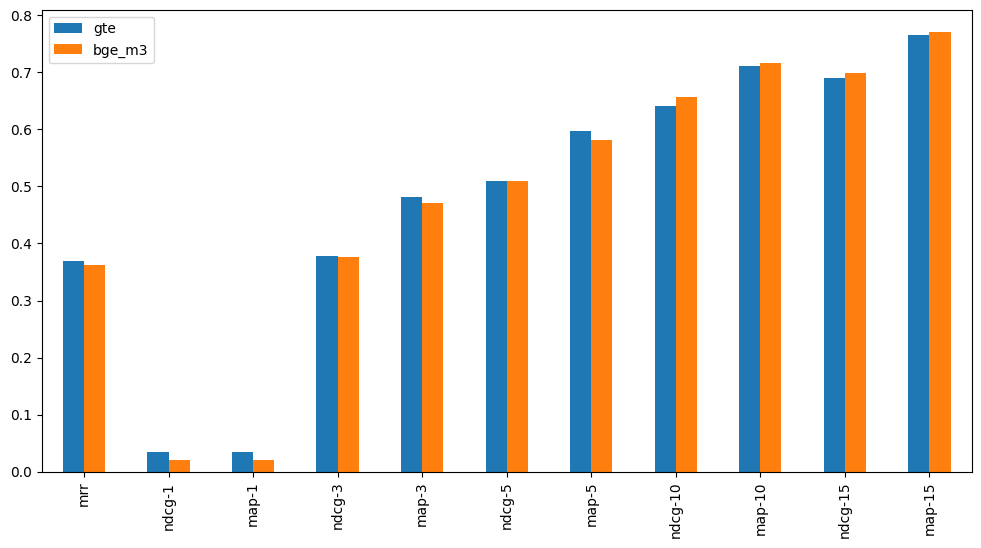

In [93]:
embedding_models_data.T.plot(kind='bar', figsize=(12,6))

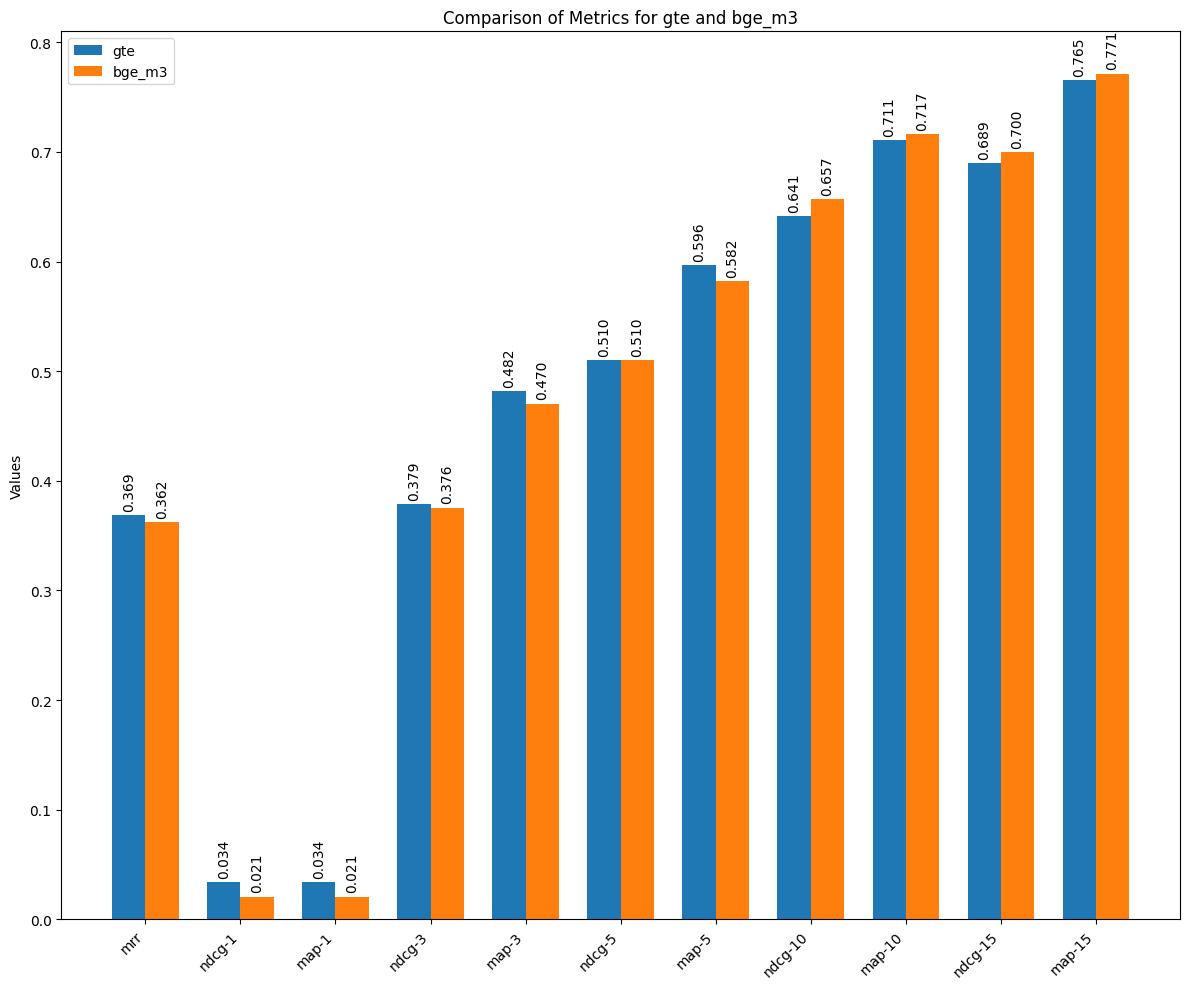

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame
data = {'mrr': [0.368558, 0.362428],
        'ndcg-1': [0.033962, 0.020755],
        'map-1': [0.033962, 0.020755],
        'ndcg-3': [0.378799, 0.375584],
        'map-3': [0.481918, 0.470440],
        'ndcg-5': [0.510418, 0.509789],
        'map-5': [0.596407, 0.582170],
        'ndcg-10': [0.641473, 0.656934],
        'map-10': [0.711034, 0.716593],
        'ndcg-15': [0.689453, 0.699651],
        'map-15': [0.765243, 0.771375]}

# Create the DataFrame
df = pd.DataFrame(data, index=['gte', 'bge_m3'])

# Plot settings
metrics = df.columns  # Metrics for x-axis
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the bars for gte and bge_m3
rects1 = ax.bar(x - width/2, df.loc['gte'], width, label='gte')
rects2 = ax.bar(x + width/2, df.loc['bge_m3'], width, label='bge_m3')

# Add text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics for gte and bge_m3')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.legend()

# Function to add labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',  # format the label
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # x and y position
                    xytext=(0, 3),  # vertical space above bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)  # Rotate text vertically

# Add labels on top of bars
add_labels(rects1)
add_labels(rects2)

# Adjust layout to fit everything
fig.tight_layout()

# Show the plot
plt.show()

In [104]:
 standard_similarities.iloc[0:1590, 0:1590]

,0,1,2,3,4,5,6,7,8,9,...,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589
0,0.000000,0.187929,0.415178,0.383166,0.466611,0.375390,0.403419,0.464105,0.305925,0.434399,...,0.084167,0.115486,0.069588,0.142101,0.101407,0.101677,0.092388,0.058865,0.132498,0.103376
1,0.187929,0.000000,0.256370,0.120109,0.292366,0.223582,0.300731,0.283809,0.288504,0.175110,...,0.071771,0.034137,0.033414,0.103679,0.042185,0.093878,0.009727,0.025217,0.107151,0.047183
2,0.415178,0.256370,0.000000,0.329294,0.511605,0.595690,0.440191,0.452678,0.373044,0.670651,...,0.214155,0.175976,0.151471,0.273039,0.182963,0.227927,0.161184,0.151059,0.289864,0.183658
3,0.383166,0.120109,0.329294,0.000000,0.374067,0.297499,0.490352,0.264241,0.326967,0.334943,...,0.121875,0.192057,0.134689,0.176667,0.173989,0.168183,0.173470,0.118986,0.171526,0.179924
4,0.466611,0.292366,0.511605,0.374067,0.000000,0.492403,0.641158,0.472598,0.619545,0.546687,...,0.248120,0.246193,0.185294,0.315557,0.249140,0.270131,0.228170,0.171286,0.308052,0.254901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,0.101677,0.093878,0.227927,0.168183,0.270131,0.168091,0.224234,0.099938,0.191182,0.219727,...,0.895832,0.658814,0.685262,0.784780,0.688352,0.000000,0.638689,0.698107,0.791889,0.687020
1586,0.092388,0.009727,0.161184,0.173470,0.228170,0.172122,0.166913,0.012848,0.126400,0.173244,...,0.629058,0.895479,0.625764,0.659453,0.922251,0.638689,0.000000,0.600859,0.636479,0.920600
1587,0.058865,0.025217,0.151059,0.118986,0.171286,0.109985,0.189074,0.044238,0.110789,0.156348,...,0.677390,0.630094,0.949649,0.694060,0.647729,0.698107,0.600859,0.000000,0.693808,0.654949
1588,0.132498,0.107151,0.289864,0.171526,0.308052,0.206932,0.269565,0.167352,0.171384,0.260828,...,0.761320,0.667335,0.676960,0.964614,0.689175,0.791889,0.636479,0.693808,0.000000,0.694767


In [259]:
import pandas as pd

class Plot:
    def __init__(self, standard_similarities, comparing_similarities, model_name):
        self.standard_similarities = standard_similarities
        self.comparing_similarities = comparing_similarities
        self.model_name = model_name


    def calculate_metrics(self, a, b):
        base = self.standard_similarities.iloc[a[0]: a[1], b[0]: b[1]]
        comparison = self.comparing_similarities.iloc[a[0]: a[1], b[0]: b[1]]
        
        mrr = calculate_mrr(base, comparison)
        ndcg_1 = calculate_ndcg(base, comparison, 1)
        map_1 = calculate_map(base, comparison, 1)
        ndcg_3 = calculate_ndcg(base, comparison, 3)
        map_3 = calculate_map(base, comparison, 3)
        ndcg_5 = calculate_ndcg(base, comparison, 5)
        map_5 = calculate_map(base, comparison, 5)
        ndcg_10 = calculate_ndcg(base, comparison, 10)
        map_10 = calculate_map(base, comparison, 10)
        ndcg_15 = calculate_ndcg(base, comparison, 15)
        map_15 = calculate_map(base, comparison, 15)
    
        data = [mrr, ndcg_1, map_1, ndcg_3, map_3, ndcg_5, map_5, ndcg_10, map_10, ndcg_15, map_15]
        return data
        
        
    def relative_plot(self):
        language_metrics = pd.DataFrame(index=['mrr', 'ndcg-1', 'map-1', 'ndcg-3', 'map-3', 'ndcg-5', 'map-5', 'ndcg-10', 'map-10', 'ndcg-15', 'map-15'],dtype=float)
     
        language_metrics.loc[:, 'Fa'] = self.calculate_metrics([530, 1060], [530, 1060])
        language_metrics.loc[:, 'Fa-En'] = self.calculate_metrics([0, 1060], [0, 1060])
        language_metrics.loc[:, 'Fa-Ar'] = self.calculate_metrics([530, 1590], [530, 1590])
        language_metrics.loc[:, 'mixed'] = self.calculate_metrics([0, 1590], [0, 1590])
        
        metrics = language_metrics.index  
        num_components = len(language_metrics.columns) 
        x = np.arange(len(metrics))  
        width = 0.8 / num_components  
        
        fig, ax = plt.subplots(figsize=(20, 10))
        
        for i, component in enumerate(language_metrics.columns):
            bar_positions = x - (width * (num_components / 2)) + (i * width) + (width / 2)
            ax.bar(bar_positions, language_metrics[component], width, label=component)
            
            # Add labels on top of bars
            for rect in ax.patches:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', rotation=90)
        
        ax.set_ylabel('Values')
        ax.set_title(f'Comparison of Metrics for Multiple Situations ({self.model_name})')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, ha="right")
        ax.legend()
        
        fig.tight_layout()
        
        plt.show()
    
        return language_metrics

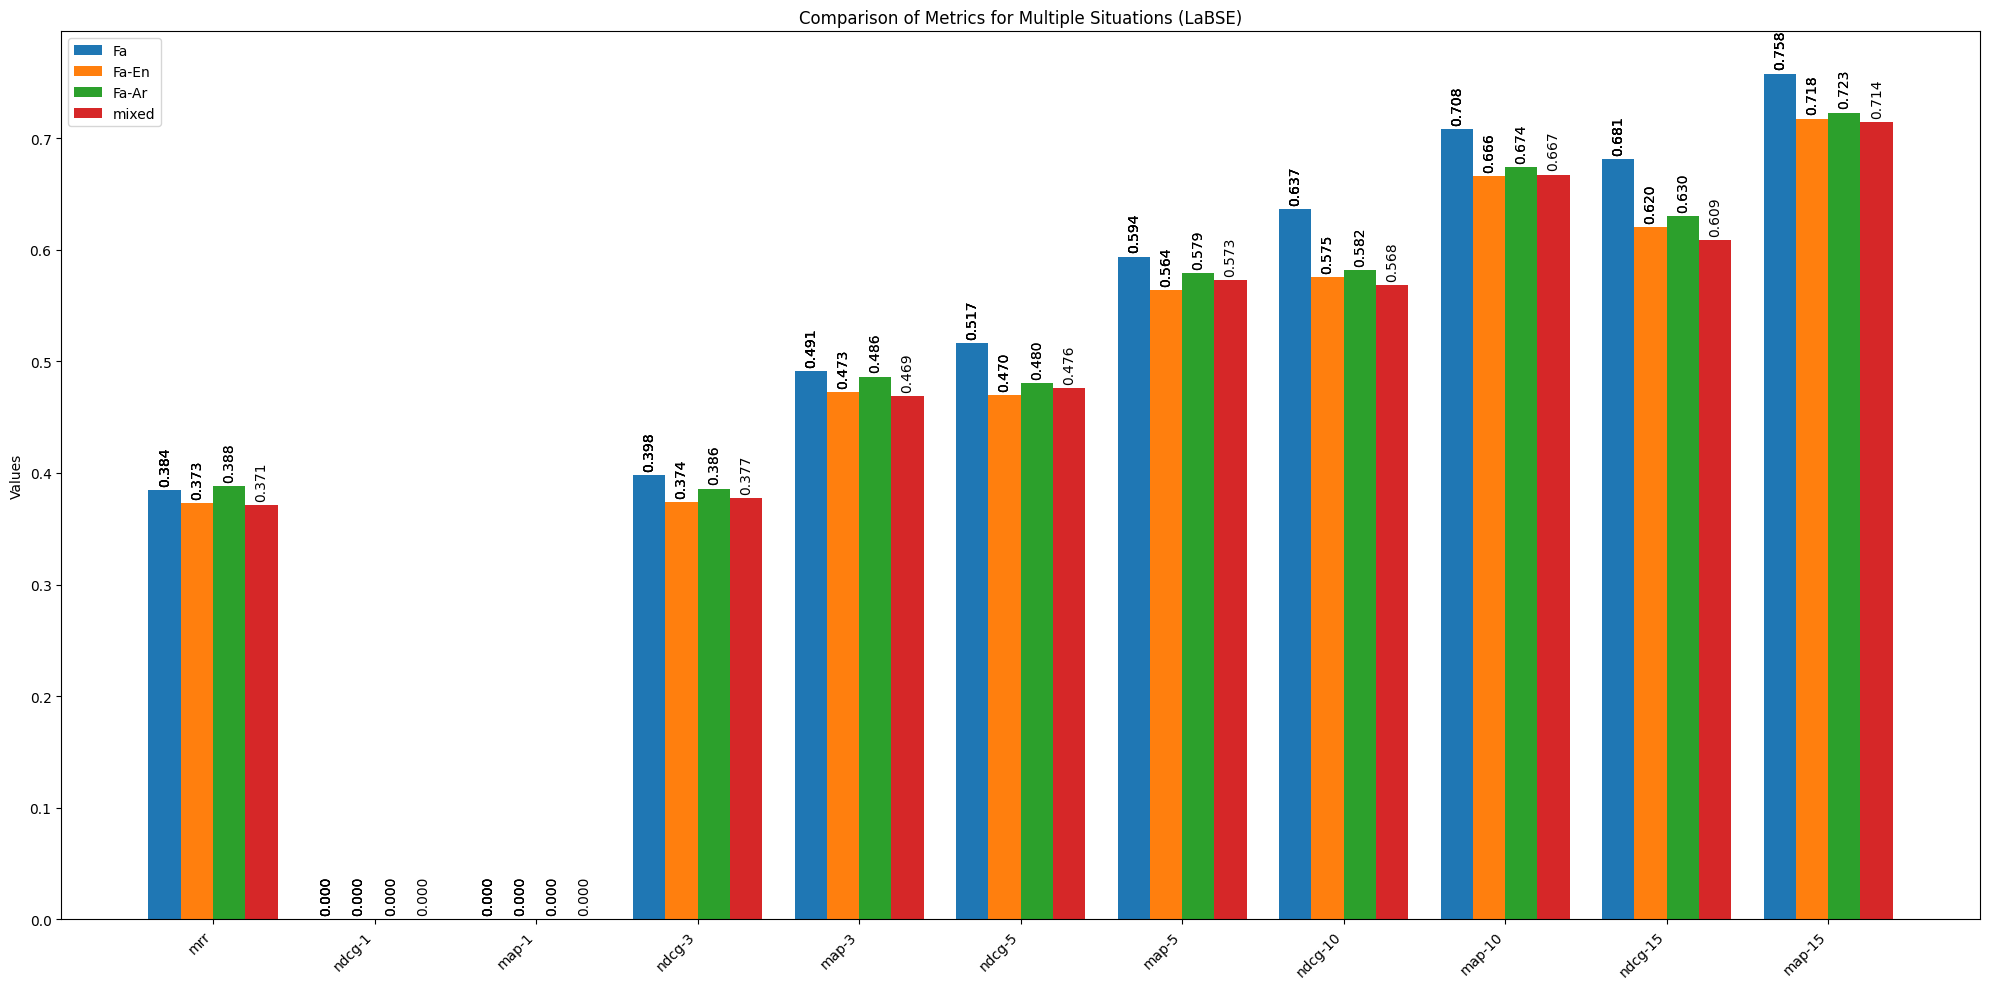

In [261]:
a = Plot(standard_similarities, gte_similarities, 'LaBSE')
b = a.relative_plot()

In [187]:
df

,English Sentence,Persian Sentence,Arabic Sentence,Subject,Tone,Emotion,Dialogue Type,Number of Tokens
0,"During World War II, millions of innocent peop...",در دوران جنگ جهانی دوم، میلیون‌ها نفر از مردم ...,خلال الحرب العالمية الثانية، قُتل ملايين من ال...,"History (war, literature, art)",formal,neutral,administrative,64
1,"In Iranian literature, Ferdowsi's epic poems h...",در ادبیات ایران، اشعار حماسی فردوسی همواره به...,في الأدب الإيراني، تُعتبر أشعار فردوسي البطولي...,"History (war, literature, art)",formal,positive,administrative,64
2,"Throughout history, artists have always tried ...",هنرمندان در طول تاریخ همواره تلاش کرده‌اند تا...,على مرّ التاريخ، حاول الفنانون دائماً من خلال ...,"History (war, literature, art)",formal,positive,administrative,64
3,"Civil wars in many countries, besides causing ...",جنگ‌های داخلی در بسیاری از کشورها، علاوه بر خ...,الحروب الأهلية في العديد من البلدان، بالإضافة ...,"History (war, literature, art)",contemptuous,negative,administrative,64
4,Many war stories have successfully portrayed a...,بسیاری از داستان‌های جنگی به خوبی توانسته‌اند...,العديد من قصص الحرب نجحت في عرض صورة واقعية من...,"History (war, literature, art)",friendly,neutral,formal,64
...,...,...,...,...,...,...,...,...
525,"Cinema, as a comprehensive and complex art for...",۱. سینما به عنوان یک هنر جامع و پیچیده، توانست...,السينما كفن شامل ومعقد، استطاعت خلال العقود ال...,"Cinema, Philosophy, Art history",friendly,positive,casual,512
526,"Unfortunately, many films that address philoso...",۲. متأسفانه، بسیاری از فیلم‌هایی که به بررسی م...,للأسف، العديد من الأفلام التي تتناول القضايا ا...,"Cinema, Philosophy, Art history",derisive,negative,casual,512
527,Analyzing the impact of cinema on philosophica...,۳. تحلیل تأثیرات سینما بر مفاهیم فلسفی و تاریخ...,في تحليل تأثيرات السينما على المفاهيم الفلسفية...,"Cinema, Philosophy, Art history",completely,neutral,administrative,512
528,Films that explore historical and philosophica...,۴. فیلم‌های سینمایی که به موضوعات تاریخی و فلس...,الأفلام التي تتناول المواضيع التاريخية والفلسف...,"Cinema, Philosophy, Art history",friendly,positive,local,512


In [188]:
standard_similarities

,0,1,2,3,4,5,6,7,8,9,...,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589
0,0.000000,0.187929,0.415178,0.383166,0.466611,0.375390,0.403419,0.464105,0.305925,0.434399,...,0.084167,0.115486,0.069588,0.142101,0.101407,0.101677,0.092388,0.058865,0.132498,0.103376
1,0.187929,0.000000,0.256370,0.120109,0.292366,0.223582,0.300731,0.283809,0.288504,0.175110,...,0.071771,0.034137,0.033414,0.103679,0.042185,0.093878,0.009727,0.025217,0.107151,0.047183
2,0.415178,0.256370,0.000000,0.329294,0.511605,0.595690,0.440191,0.452678,0.373044,0.670651,...,0.214155,0.175976,0.151471,0.273039,0.182963,0.227927,0.161184,0.151059,0.289864,0.183658
3,0.383166,0.120109,0.329294,0.000000,0.374067,0.297499,0.490352,0.264241,0.326967,0.334943,...,0.121875,0.192057,0.134689,0.176667,0.173989,0.168183,0.173470,0.118986,0.171526,0.179924
4,0.466611,0.292366,0.511605,0.374067,0.000000,0.492403,0.641158,0.472598,0.619545,0.546687,...,0.248120,0.246193,0.185294,0.315557,0.249140,0.270131,0.228170,0.171286,0.308052,0.254901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,0.101677,0.093878,0.227927,0.168183,0.270131,0.168091,0.224234,0.099938,0.191182,0.219727,...,0.895832,0.658814,0.685262,0.784780,0.688352,0.000000,0.638689,0.698107,0.791889,0.687020
1586,0.092388,0.009727,0.161184,0.173470,0.228170,0.172122,0.166913,0.012848,0.126400,0.173244,...,0.629058,0.895479,0.625764,0.659453,0.922251,0.638689,0.000000,0.600859,0.636479,0.920600
1587,0.058865,0.025217,0.151059,0.118986,0.171286,0.109985,0.189074,0.044238,0.110789,0.156348,...,0.677390,0.630094,0.949649,0.694060,0.647729,0.698107,0.600859,0.000000,0.693808,0.654949
1588,0.132498,0.107151,0.289864,0.171526,0.308052,0.206932,0.269565,0.167352,0.171384,0.260828,...,0.761320,0.667335,0.676960,0.964614,0.689175,0.791889,0.636479,0.693808,0.000000,0.694767


In [254]:
en_first = standard_similarities.iloc[:,:5]
ar_first = standard_similarities.iloc[:,1060:1065]

In [248]:
first_10_fa = standard_similarities.iloc[:,530:540]

In [230]:
first_10_fa.iloc[:,0].sort_values(ascending=False)

1060    0.744916
560     0.650282
1090    0.540537
570     0.531622
534     0.529606
          ...   
1096    0.317831
34      0.316082
1107    0.315360
1109    0.314639
9       0.313830
Name: 530, Length: 100, dtype: float64

In [249]:
first_10_fa

,530,531,532,533,534,535,536,537,538,539
0,0.711976,0.162737,0.365514,0.249742,0.405794,0.303574,0.342665,0.271129,0.268125,0.397377
1,0.232110,0.589316,0.323213,0.199972,0.287138,0.282894,0.317891,0.266534,0.275088,0.225420
2,0.299614,0.231043,0.690628,0.262762,0.434138,0.503566,0.375284,0.314518,0.315971,0.587627
3,0.274691,0.109770,0.283086,0.655671,0.316956,0.251360,0.401258,0.144134,0.273478,0.257570
4,0.392841,0.208747,0.465503,0.290974,0.760306,0.414971,0.570983,0.322346,0.482290,0.485545
...,...,...,...,...,...,...,...,...,...,...
1585,0.146304,0.125234,0.259868,0.205666,0.348825,0.227621,0.236250,0.177952,0.203228,0.261340
1586,0.128300,0.053618,0.198420,0.217249,0.298816,0.188520,0.176406,0.084384,0.186573,0.218237
1587,0.069971,0.066051,0.192107,0.157710,0.231937,0.144619,0.189027,0.122729,0.117795,0.170263
1588,0.146199,0.125057,0.291566,0.220261,0.347821,0.248361,0.274832,0.191771,0.158288,0.268077


In [247]:
standard_similarities

,0,1,2,3,4,5,6,7,8,9,...,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589
0,0.000000,0.187929,0.415178,0.383166,0.466611,0.375390,0.403419,0.464105,0.305925,0.434399,...,0.084167,0.115486,0.069588,0.142101,0.101407,0.101677,0.092388,0.058865,0.132498,0.103376
1,0.187929,0.000000,0.256370,0.120109,0.292366,0.223582,0.300731,0.283809,0.288504,0.175110,...,0.071771,0.034137,0.033414,0.103679,0.042185,0.093878,0.009727,0.025217,0.107151,0.047183
2,0.415178,0.256370,0.000000,0.329294,0.511605,0.595690,0.440191,0.452678,0.373044,0.670651,...,0.214155,0.175976,0.151471,0.273039,0.182963,0.227927,0.161184,0.151059,0.289864,0.183658
3,0.383166,0.120109,0.329294,0.000000,0.374067,0.297499,0.490352,0.264241,0.326967,0.334943,...,0.121875,0.192057,0.134689,0.176667,0.173989,0.168183,0.173470,0.118986,0.171526,0.179924
4,0.466611,0.292366,0.511605,0.374067,0.000000,0.492403,0.641158,0.472598,0.619545,0.546687,...,0.248120,0.246193,0.185294,0.315557,0.249140,0.270131,0.228170,0.171286,0.308052,0.254901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,0.101677,0.093878,0.227927,0.168183,0.270131,0.168091,0.224234,0.099938,0.191182,0.219727,...,0.895832,0.658814,0.685262,0.784780,0.688352,0.000000,0.638689,0.698107,0.791889,0.687020
1586,0.092388,0.009727,0.161184,0.173470,0.228170,0.172122,0.166913,0.012848,0.126400,0.173244,...,0.629058,0.895479,0.625764,0.659453,0.922251,0.638689,0.000000,0.600859,0.636479,0.920600
1587,0.058865,0.025217,0.151059,0.118986,0.171286,0.109985,0.189074,0.044238,0.110789,0.156348,...,0.677390,0.630094,0.949649,0.694060,0.647729,0.698107,0.600859,0.000000,0.693808,0.654949
1588,0.132498,0.107151,0.289864,0.171526,0.308052,0.206932,0.269565,0.167352,0.171384,0.260828,...,0.761320,0.667335,0.676960,0.964614,0.689175,0.791889,0.636479,0.693808,0.000000,0.694767


In [256]:
test = {0:'English Sentence', 1:'Persian Sentence'	,2:'Arabic Sentence'}
columns = ar_first.columns
for i in ar_first:
    print("Main Text: \n\t" , df.loc[int(i) % 530, test[int(i) // 530]])

    most_similar = ar_first.loc[:, i].sort_values(ascending=False).index.tolist()[:15]

    for j in range(len(most_similar)):
        print(f"\t\tSimilar text number {j}: \n\t\t" , df.loc[most_similar[j] % 530, test[most_similar[j] // 530]])
    
    

Main Text: 
	 خلال الحرب العالمية الثانية، قُتل ملايين من الأبرياء وخلّفت دماراً واسعاً، ولكن شجاعة وصمود الشعوب أيضاً سُجلت في الذاكرة. 
		Similar text number 0: 
		 در دوران جنگ جهانی دوم، میلیون‌ها نفر از مردم بی‌گناه کشته شدند و ویرانی‌های بسیاری به جا ماند، ولی شجاعت و مقاومت ملت‌ها نیز در خاطره‌ها ثبت شد. 
		Similar text number 1: 
		 During World War II, millions of innocent people were killed, and many destructions were left behind, but the courage and resistance of the nations were also recorded in memory.
		Similar text number 2: 
		 الحرب العالمية الثانية كانت واحدة من أعظم وأكثر الحروب تدميراً في تاريخ البشرية، حيث أودت بحياة الملايين وسببت دماراً هائلاً في العالم؛ ومع ذلك، في وسط كل هذه الظلمات، كان هناك أبطال مجهولون قد غيّروا مصير الشعوب بشجاعتهم وتضحياتهم. هؤلاء الأبطال، على الرغم من ندرة ظهور أسمائهم في صفحات التاريخ الكبرى، إلا أنهم يحتلون مكانة خاصة في قلوب وأرواح الشعوب. الأدب والفن في هذه الفترة حاولوا أن يحافظوا على ذكريات هؤلاء الأبطال من خلال القصص والشعر واللوح

In [245]:
standard_similarities.iloc[:,530].sort_values(ascending=False)

1060    0.744916
0       0.711976
560     0.650282
1090    0.540537
570     0.531622
          ...   
248    -0.043217
152    -0.043924
161    -0.046131
414    -0.046370
270    -0.051562
Name: 530, Length: 1590, dtype: float64

In [240]:
standard_similarities.iloc[0].sort_values(ascending=False)

0       1.000000
1060    0.737115
530     0.711976
30      0.685467
40      0.595021
          ...   
821    -0.055022
1242   -0.055909
1464   -0.057541
1494   -0.069921
1475   -0.072832
Name: 0, Length: 1590, dtype: float64